<a href="https://colab.research.google.com/github/emanueleiacca/ADM-HW4/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4 - Movie Recommendation System**

### #Group21
Camilla Labbate - camillalabbate02@icloud.com

Emanuele Iaccarino - emanueleiaccarino.ei@gmail.com

Andrej Sterjev - andrej.sterjev@gmail.com

## 1. **Recommendation System with LSH**

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [4]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [5]:
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


In [6]:
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()

GPU Memory - Total: 14.65 GB, Used: 0.00 GB, Free: 14.65 GB


In [7]:
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')


dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")

100%|██████████| 195M/195M [00:02<00:00, 87.1MB/s]

Extracting files...


File trovato: movie.csv
File trovato: genome_tags.csv
File trovato: tag.csv
File trovato: link.csv
File trovato: genome_scores.csv
File trovato: rating.csv


In [8]:
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")


In [9]:
check_memory()

GPU Memory - Total: 12.14 GB, Used: 0.00 GB, Free: 12.14 GB


In [10]:
print("ratings_df:",ratings_df.columns)
print("links_df:",links_df.columns)
print("genome_tags_df:",genome_tags_df.columns)
print("genome_scores_df:",genome_scores_df.columns)
print("tags_df:",tags_df.columns)
print("movies_df:",movies_df.columns)

ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links_df: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
genome_tags_df: Index(['tagId', 'tag'], dtype='object')
genome_scores_df: Index(['movieId', 'tagId', 'relevance'], dtype='object')
tags_df: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [ ]:
import gc
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
movies_links = movies_df.merge(links_df, on="movieId", how="left")
del links_df  # Free up memory
gc.collect()
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,4110,"Fourth Protocol, The (1987)",Thriller,93044,4918
1,4111,Gardens of Stone (1987),Drama|War,93073,28368
2,4112,Julia and Julia (Giulia e Giulia) (1987),Drama|Mystery|Thriller,93092,58084
3,4113,"Glass Menagerie, The (1987)",Drama,93093,52780
4,4114,"Good Morning, Babylon (1987)",Drama,93104,48149


In [ ]:
# Merge ratings with movies
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
ratings_movies = ratings_df.merge(movies_links, on="movieId", how="left")
del ratings_df, movies_links  # Free up memory
gc.collect()
ratings_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,91,165,3.5,2005-07-18 07:58:38,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,112864,1572
1,91,168,2.5,2005-09-12 06:49:36,First Knight (1995),Action|Drama|Romance,113071,6520
2,91,172,2.5,2005-09-12 06:48:40,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,113481,9886
3,91,173,3.0,2005-07-18 08:13:32,Judge Dredd (1995),Action|Crime|Sci-Fi,113492,9482
4,91,185,2.5,2005-07-18 08:00:21,"Net, The (1995)",Action|Crime|Thriller,113957,1642


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
# Merge genome scores with genome tags
genome_data = genome_scores_df.merge(genome_tags_df, on="tagId", how="left")
del genome_tags_df  # Free up memory
gc.collect()
genome_data.head()

,movieId,tagId,relevance,tag
0,1,65,0.10100,anime
1,1,66,0.03750,antarctica
2,1,67,0.12075,anti-hero
3,1,68,0.03775,anti-semitism
4,1,69,0.02000,anti-war


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)
# Merge tags with movies
tags_movies = tags_df.merge(movies_df, on="movieId", how="left")
del tags_df  # Free up memory
gc.collect()
tags_movies.head()

,userId,movieId,tag,timestamp,title,genres
0,964,1197,fairy tale,2010-10-09 17:10:13,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
1,964,1197,fantasy,2010-10-09 17:10:14,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
2,964,1197,funny,2010-10-09 17:10:18,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
3,964,1197,good versus evil,2010-10-09 17:10:20,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
4,964,1197,imdb top 250,2010-10-09 17:10:16,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance


In [ ]:
check_memory()

GPU Memory - Total: 9.64 GB, Used: 0.00 GB, Free: 9.64 GB


In [ ]:
print("ratings_movies:",ratings_movies.columns)
print("genome_data:",genome_data.columns)
print("tags_movies:",tags_movies.columns)

ratings_movies: Index(['userId', 'movieId', 'rating', 'title', 'genres', 'timestamp'], dtype='object')
genome_data: Index(['movieId', 'tagId', 'relevance', 'tag'], dtype='object')
tags_movies: Index(['userId', 'movieId', 'tag', 'timestamp', 'title', 'genres'], dtype='object')


In [ ]:
ratings_movies = ratings_movies[["userId", "movieId", "rating", "title", "genres","timestamp"]]
genome_data = genome_data[["movieId", "tag", "relevance"]]
tags_movies = tags_movies[["userId", "movieId", "tag"]]
#Remove repeated columns

In [ ]:
print("ratings_movies:",ratings_movies.info())
print("genome_data:",genome_data.info())
print("tags_movies:",tags_movies.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     float64
 3   title      object
 4   genres     object
 5   timestamp  object
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ GB
ratings_movies: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   movieId    int64
 1   tag        object
 2   relevance  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 335.2+ MB
genome_data: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   465426 non-null  int64
 1   movieId  465426 non-null  int64
 2   tag      465426 non-null  object
dtypes: int

### 1.1 Data Preparation

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from itertools import combinations
from collections import defaultdict


In [12]:
movies_df_pd = movies_df.to_pandas()
rating_df_pd=ratings_df.to_pandas()
tags_df_pd=tags_df.to_pandas()
genome_tags_df_pd=genome_tags_df.to_pandas()
genome_scores_df_pd=genome_scores_df.to_pandas()
links_df_pd=links_df.to_pandas()

In [13]:
print("\nInfo about dataset 'movies':")
print(movies_df_pd.info())

print("\nInfo about dataset 'ratings':")
print(rating_df_pd.info())


print("\nInfo about dataset 'tag':")
print(tags_df_pd.info())

print("\nInfo about dataset 'genome_tags':")
print(genome_tags_df_pd.info())


print("\nInfo about dataset  'genome_scores':")
print(genome_scores_df_pd.info())

print("\nInfo about dataset 'link':")
print(links_df_pd.info())

display(movies_df_pd.head())
display(rating_df_pd.head())
display(tags_df_pd.head())
display(genome_tags_df_pd.head())
display(genome_scores_df_pd.head())
display(links_df_pd.head())


Info about dataset 'movies':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Info about dataset 'ratings':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None

Info about dataset 'tag':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465426 non-null  int64 
 1   

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
print(rating_df_pd.isnull().sum())
print(movies_df_pd.isnull().sum())
print(tags_df_pd.isnull().sum())
print(links_df_pd.isnull().sum())
print(genome_scores_df_pd.isnull().sum())
print(genome_tags_df_pd.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId      0
imdbId       0
tmdbId     252
dtype: int64
movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64


In [15]:
rating_df=rating_df_pd.drop_duplicates()
movies_df=movies_df_pd.drop_duplicates()
tags_df=tags_df_pd.drop_duplicates()
links_df=links_df_pd.drop_duplicates()
genome_scores_df=genome_scores_df_pd.drop_duplicates()
genome_tags_df=genome_tags_df_pd.drop_duplicates()


In [14]:
print("\nexploring dataset 'ratings':")
print(rating_df_pd.describe())

print("\nexploring dataset'movies':")
print(movies_df_pd.describe(include='all'))

print("\nexploring dataset 'link':")
print(links_df_pd.describe())

print("\nexploring dataset'tag':")
print(tags_df_pd.describe(include='all'))

print("\nexploring dataset 'genome_scores':")
print(genome_scores_df_pd.describe())

print("\nexploring dataset'genome_tags':")
print(genome_tags_df_pd.describe(include='all'))


exploring dataset 'ratings':
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

exploring dataset'movies':
              movieId           title genres
count    27278.000000           27278  27278
unique            NaN           27262   1342
top               NaN  Aladdin (1992)  Drama
freq              NaN               2   4520
mean     59855.480570             NaN    NaN
std      44429.314697             NaN    NaN
min          1.000000             NaN    NaN
25%       6931.250000             NaN    NaN
50%      68068.000000             NaN    NaN
75%     100293.250000             NaN    NaN
max     131262.

In [15]:
movies_df_pd['genres'] = movies_df_pd['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')


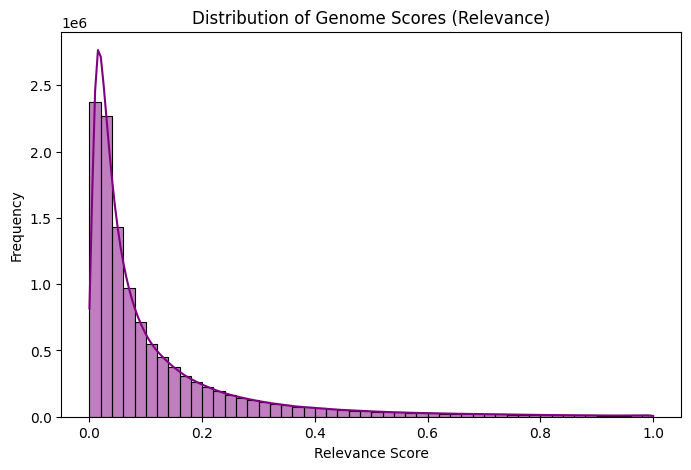

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(genome_scores_df_pd['relevance'], bins=50, kde=True, color='purple')
plt.title('Distribution of Genome Scores (Relevance)')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

There are noticeable peaks around ratings like 3.0, 4.0, and 5.0, suggesting that many users tend to give these scores.
Ratings below 2.0 are much less frequent.
The dataset might have a tendency towards higher ratings, indicating a positive skew (more ratings closer to 4 or 5).

This distribution suggests that users tend to rate movies positively, with most ratings clustering around 3 to 5. This behavior is common in user-generated rating datasets, where extreme negative ratings are less frequent.

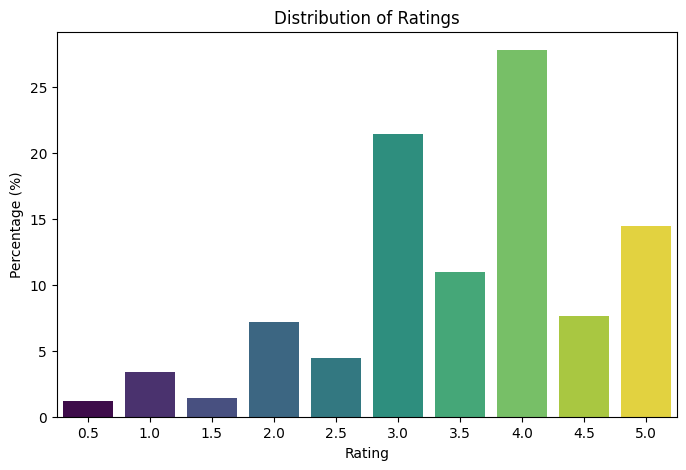

In [17]:
rating_counts = rating_df_pd['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    x=rating_counts.index,
    y=(rating_counts.values / rating_counts.sum()) * 100,
    hue=rating_counts.index,
    palette='viridis',
    legend=False
)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.show()


This bar chart represents the **distribution of ratings** provided by users. The x-axis shows the rating values (likely on a scale from 0.5 to 5.0), and the y-axis represents the **percentage of users** who gave each rating.

1. **Dominant Ratings**:
   - The most frequent rating is **4.0**, making up the highest percentage (over 25%).
   - Ratings of **3.0** and **5.0** also have a notable percentage, suggesting they are common choices among users.

2. **Low Ratings**:
   - Ratings below 2.0 (e.g., 0.5, 1.0) are less frequent, accounting for a minimal percentage of the distribution.

3. **Trend**:
   - The chart shows a positive skew: as ratings increase toward 4.0, the percentage grows, but it slightly drops for the maximum rating of **5.0**.


   - This distribution suggests that most users tend to rate movies in the mid-to-high range (3.0–4.0), with relatively few users assigning very low or extremely high ratings.


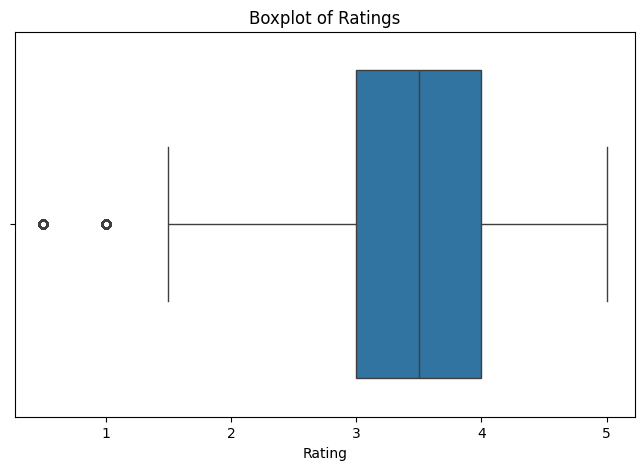

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=rating_df_pd['rating'])
plt.title('Boxplot of Ratings')
plt.xlabel('Rating')
plt.show()

The box represents the interquartile range (IQR), which contains the middle 50% of the data (from the first quartile Q1 to the third quartile Q3).
The line inside the box represents the median, indicating the middle value of the dataset.
The whiskers extend to the smallest and largest values within 1.5 times the IQR.
Two outliers are visible as individual points outside the whiskers. These are ratings below the lower whisker threshold.
The data seems to show a concentration of ratings between 3 and 4, with a few low outliers around 1.







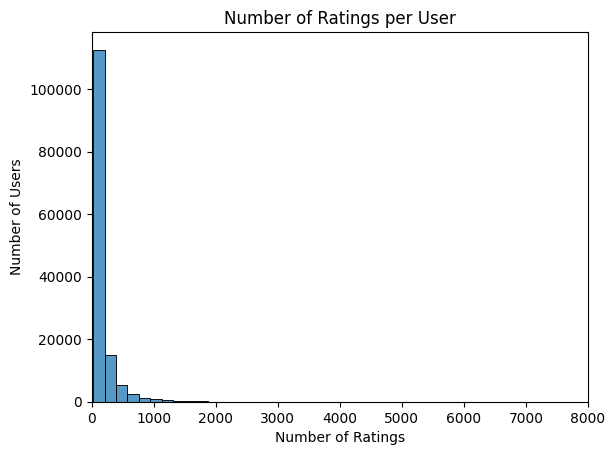

In [ ]:
user_ratings_count = rating_df_pd['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xlim(0, 8000)
plt.show()

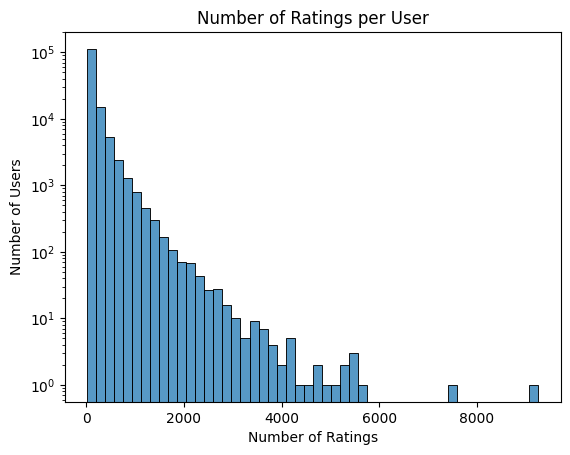

In [ ]:
user_ratings_count = rating_df_pd['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.yscale('log')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()



- **X-Axis**: "Number of Ratings" — Represents the number of ratings provided by individual users.
- **Y-Axis**: "Number of Users" — Represents the number of users corresponding to a particular number of ratings.
- The Y-axis is plotted on a **logarithmic scale**, as indicated by the uneven spacing of numbers (e.g., \(10^0, 10^1, 10^2, \dots\)).

- The data shows a **right-skewed distribution**.
- Most users have given very few ratings, as shown by the tall bar on the left-hand side of the histogram.
- A small number of users have provided significantly more ratings, as indicated by the sparse bars extending towards higher numbers of ratings (up to around 9000).
- The frequency of users decreases rapidly as the number of ratings increases.

This suggests that the majority of users are less active, while a small subset of users are highly active in providing ratings.

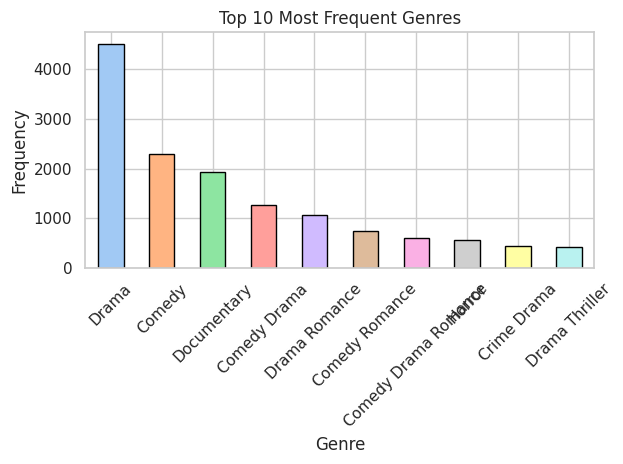

In [ ]:
movies_df_pd['genres'] = movies_df_pd['genres'].dropna().astype(str).str.split('|')

# Flatten the list of genres
all_genres = [genre for sublist in movies_df_pd['genres'] for genre in sublist]

# Count genre occurrences and get the top 10
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Plot with a custom Seaborn palette
sns.set(style="whitegrid")
palette = sns.color_palette("pastel", 10)

# Create the bar chart
genre_counts.plot(kind='bar', color=palette, edgecolor='black')

# Add titles and labels
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutting off labels
plt.show()

This bar chart represents the **distribution of top 10 frequent genres** watched by users. The x-axis shows the genres, and the y-axis represents the **the frequency** with which they were watched.

- In the chart above, it is possible to observe the 10 most-watched film genres by users on the platform. According to the chart, the most captivating genre is Drama, followed by Comedy and Documentary.
- According to the chart, the most captivating genre is Drama, followed by Comedy and Documentary.

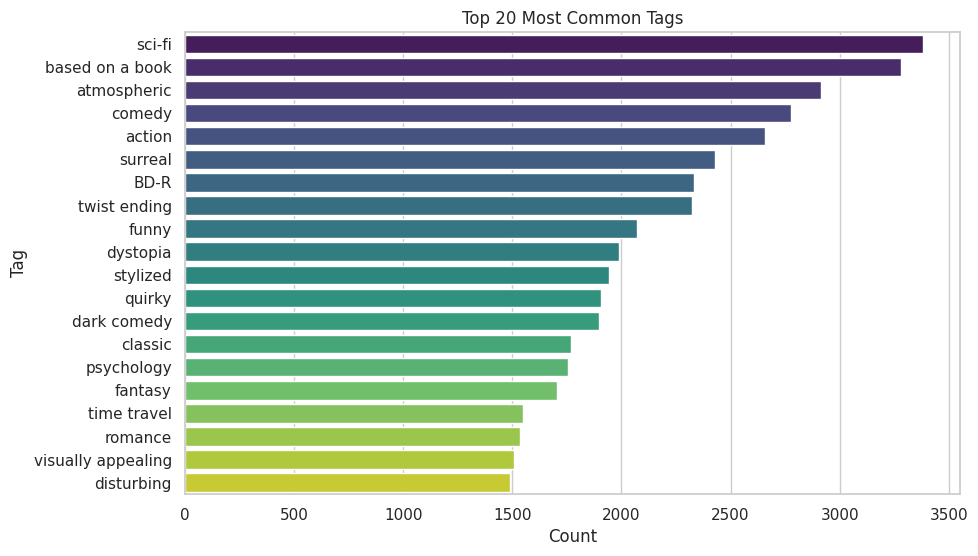

In [ ]:
tag_counts = tags_df_pd['tag'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='viridis', hue=tag_counts.index, label=None)  # Set label to None to disable legend
plt.title('Top 20 Most Common Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

The graph displays the **Top 20 Most Common Tags** associated with movies, ranked by their frequency of appearance .

- The horizontal bars represent the count of occurrences for each tag, with longer bars indicating higher frequency.
- The y-axis lists the movie tags.
- The x-axis represents the count of times each tag was used, ranging from 0 to approximately 3500.

1. **"sci-fi"** is the most frequently used tag, with nearly 3500 occurrences.
2. Tags such as **"based on a book"**, **"atmospheric"**, and **"comedy"** follow closely, indicating their popularity or prevalence in the dataset.
3. The least common tags in this top 20 list, such as **"visually appealing"** and **"disturbing"**, still have notable counts but less compared to the leading tags.

The color gradient likely helps emphasize the frequency, with darker shades representing higher counts and lighter shades for lower counts.

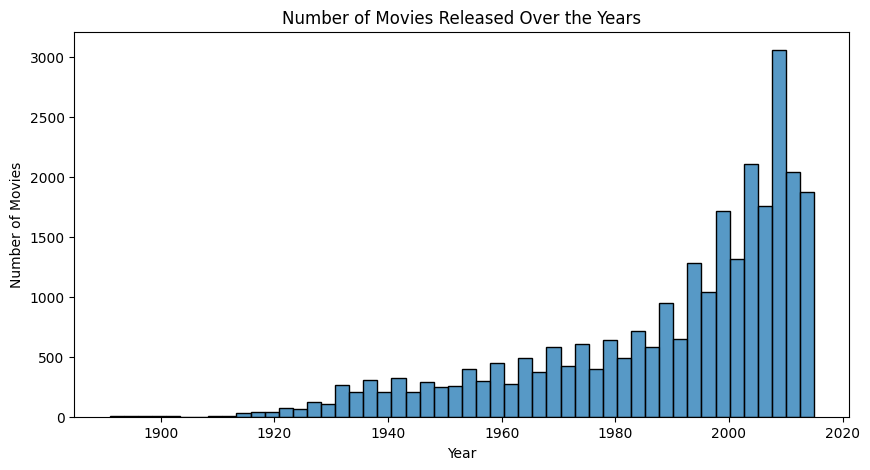

In [ ]:
# Extract release year from the title (assuming format: "Movie Title (Year)")
movies_df_pd['year'] = movies_df_pd['title'].str.extract(r'\((\d{4})\)').astype(float)

# Plot movie releases by year
plt.figure(figsize=(10, 5))
sns.histplot(movies_df_pd['year'].dropna(), bins=50, kde=False)
plt.title('Number of Movies Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()


- There is a **steady increase** in the number of movies released over time, particularly after 1960.
- The rate of movie releases accelerates significantly after 1980, with a sharp rise leading up to the early 2000s.
- The highest number of movies released is observed around the early 2000s, peaking just before 2020.
- Earlier years, particularly before 1920, show a minimal number of releases, which gradually increase.

This trend indicates growth in the movie industry, particularly in the latter half of the 20th century, likely due to advancements in technology, increased global demand, and accessibility to filmmaking resources.

## 1.2 Minhash Signatures

In [60]:
min_users_per_movie = 5  # Soglia minima: un film deve essere visto da almeno 5 utenti
movie_counts = rating_df_pd['movieId'].value_counts()
valid_movies = movie_counts[movie_counts >= min_users_per_movie].index

# Filtra gli utenti che hanno visto pochi film
min_movies_per_user = 5  # Soglia minima: un utente deve aver visto almeno 5 film
user_counts = rating_df_pd['userId'].value_counts()
valid_users = user_counts[user_counts >= min_movies_per_user].index

# Applica i filtri al DataFrame
filtered_rating_df = rating_df_pd[
    (rating_df_pd['movieId'].isin(valid_movies)) &
    (rating_df_pd['userId'].isin(valid_users))
]


In [70]:
print(f"Numero di utenti dopo la normalizzazione: {len(user_movies)}")
print(f"Numero di film dopo la normalizzazione: {len(valid_movies)}")


Numero di utenti dopo la normalizzazione: 138493
Numero di film dopo la normalizzazione: 18345


In [61]:
user_movies = rating_df_pd.groupby('userId')['movieId'].apply(set).to_dict()

In [62]:
def jaccard_similarity_exact(movies1, movies2):
    intersection = len(movies1 & movies2)
    union = len(movies1 | movies2)
    return intersection / union if union > 0 else 0

In [63]:
def jaccard_similarity_hashed(signature1, signature2):
    matches = sum(1 for x, y in zip(signature1, signature2) if x == y)
    return matches / len(signature1)

In [64]:
def generate_hash_function(a,b,c):
    def hash_function(x):
        return (a * (x%c) + b)
    return hash_function

def generate_hash_functions(num_hashes, max_movie_id, seed=None):

    if seed is not None:
        np.random.seed(seed)
    a = np.random.randint(1, max_movie_id * 2, size=num_hashes)
    b = np.random.randint(0, max_movie_id * 2, size=num_hashes)
    c = max_movie_id * 2 + 1
    return [generate_hash_function(a_, b_, c) for a_, b_ in zip(a, b)]

In [65]:
def create_custom_hash_function(a_coeff, b_coeff, prime_mod):
    """"Defines a cubic hash function based on 2x."""
    def hash_function(input_value):
        return (a_coeff * 2 * input_value + b_coeff) % prime_mod
    return hash_function

def create_hash_function_family(num_functions, max_movie_val, random_seed=None):
    """Generates a series of hash functions using the coefficient 2x in the formula."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coefficients = np.random.randint(1, max_movie_val * 2, size=num_functions)
    b_coefficients = np.random.randint(0, max_movie_val * 2, size=num_functions)
    prime_modulo = max_movie_val * 2 + 1

    return [create_custom_hash_function(a, b, prime_modulo) for a, b in zip(a_coefficients, b_coefficients)]

In [66]:
def create_quadratic_hash_function(coeff_a, coeff_b, prime_modulo):
    """"Defines a cubic hash function based on x^2."""
    def hash_function(input_value):
        return (coeff_a * (input_value / 2) + coeff_b * input_value) % prime_modulo
    return hash_function

def create_quadratic_hash_family(num_functions, max_val, random_seed=None):
    """"Generates a series of hash functions using the coefficient x^2 in the formula."."""
    if random_seed is not None:
        np.random.seed(random_seed)

    coeff_a_list = np.random.randint(1, max_val * 2, size=num_functions)
    coeff_b_list = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_quadratic_hash_function(a, b, prime_modulo) for a, b in zip(coeff_a_list, coeff_b_list)]

In [67]:
def create_cubic_hash_function(coeff_a, coeff_b, prime_mod):
    """"Defines a cubic hash function based on x^3."""
    def hash_function(input_val):
        return (coeff_a * input_val**3 + coeff_b) % prime_mod
    return hash_function

def create_cubic_hash_family(num_functions, max_val, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coeffs = np.random.randint(1, max_val * 2, size=num_functions)
    b_coeffs = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_cubic_hash_function(a, b, prime_modulo) for a, b in zip(a_coeffs, b_coeffs)]

In [68]:
def generate_signatures(subset_users, user_movie_data, hash_functions):
    """"Create MinHash signatures for a specific group of users."""
    signatures = {}

    for user_id in subset_users:
        watched_movies = user_movie_data.get(user_id, set())

        if not watched_movies:

            signatures[user_id] = [float('inf')] * len(hash_functions)
            continue

        user_signature = []
        for hash_func in hash_functions:

            min_hash_value = min(hash_func(movie) for movie in watched_movies)
            user_signature.append(min_hash_value)

        signatures[user_id] = user_signature

    return signatures

In [69]:
def compute_mse(user_movie_data, signatures, selected_users):
    """Calculate the mean squared error (MSE) between real and estimated similarities for a set of users"""
    total_error = 0
    pair_count = 0

    for idx, user_a in enumerate(selected_users):
        for user_b in selected_users[idx + 1:]:
            # Real similarity based on the Jaccard definition.
            actual_jaccard = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])

            # "Estimated similarity using MinHash signatures."
            estimated_jaccard = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])


            total_error += (actual_jaccard - estimated_jaccard) ** 2
            pair_count += 1

    # Calculate MSE
    return (total_error / pair_count) if pair_count > 0 else 0

In [71]:
# Usa il dizionario normalizzato
selected_users = list(normalized_user_movies.keys())[:100]
selected_user_movies = {user: normalized_user_movies[user] for user in selected_users}

# Crea le famiglie di funzioni hash
hash_funcs_2x = create_hash_function_family(
    num_functions=40,
    max_movie_val=int(rating_df_pd['movieId'].max()),  # Usa il massimo valore ID film dai dati normalizzati
    random_seed=42
)

hash_funcs_quadratic = create_quadratic_hash_family(
    num_functions=40,
    max_val=int(rating_df_pd['movieId'].max()),
    random_seed=42
)

hash_funcs_cubic = create_cubic_hash_family(
    num_functions=40,
    max_val=int(rating_df_pd['movieId'].max()),
    random_seed=42
)

# Calcola le firme MinHash per ogni tipo di funzione hash
signatures_2x = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_2x).items()
}

signatures_quadratic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_quadratic).items()
}

signatures_cubic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_cubic).items()
}

# Stampa alcune firme per verificare
print("Firme MinHash con hash lineare (2x):", list(signatures_2x.items())[:5])  # Prime 5 firme
print("Firme MinHash con hash quadratico:", list(signatures_quadratic.items())[:5])
print("Firme MinHash con hash cubico:", list(signatures_cubic.items())[:5])

# Calcola il Mean Squared Error (MSE) per ciascun tipo di hash
mse_2x = compute_mse(normalized_user_movies, signatures_2x, selected_users)
mse_quadratic = compute_mse(normalized_user_movies, signatures_quadratic, selected_users)
mse_cubic = compute_mse(normalized_user_movies, signatures_cubic, selected_users)

# Stampa i risultati del MSE
print("MSE 2x:", mse_2x)
print("MSE x^2:", mse_quadratic)
print("MSE x^3:", mse_cubic)


<ipython-input-67-00c844ba0e71>:4: RuntimeWarning: overflow encountered in scalar multiply
  return (coeff_a * input_val**3 + coeff_b) % prime_mod


Firme MinHash con hash lineare (2x): [(1, [4289, 5370, 305, 143, 60, 1460, 242, 364, 404, 3021, 5535, 751, 129, 84, 552, 714, 1281, 1192, 85, 25, 652, 1307, 2538, 183, 523, 878, 64, 965, 1400, 1931, 1181, 147, 1194, 3761, 227, 775, 1882, 3410, 20, 408]), (2, [5595, 2642, 91, 19321, 6685, 1460, 3708, 6188, 1418, 6717, 5462, 5401, 1306, 102, 552, 9954, 412, 7005, 4595, 8698, 622, 1307, 7217, 3099, 95, 10050, 10665, 3705, 3376, 501, 475, 5510, 620, 4356, 1140, 1700, 2980, 990, 562, 408]), (3, [242, 1650, 2676, 1680, 1245, 1460, 2240, 1525, 404, 22733, 1250, 1361, 526, 84, 3469, 389, 2516, 1192, 1142, 4266, 637, 1222, 2630, 47, 664, 4363, 64, 37, 545, 1456, 121, 1515, 803, 932, 1140, 1700, 849, 990, 914, 408]), (4, [1491, 2696, 1937, 2155, 2095, 52350, 4271, 2922, 10294, 68989, 11999, 2676, 9734, 9777, 10445, 469, 3920, 3611, 444, 11985, 2072, 10175, 481, 27719, 1426, 12580, 1378, 10405, 6655, 3016, 10154, 963, 17203, 19460, 1140, 4800, 14468, 35345, 555, 2674]), (5, [2947, 2696, 596, 1047

In [72]:
print(f"MSE  2x: {mse_2x:.4f}")
print(f"MSE  x^2: {mse_quadratic:.4f}")
print(f"MSE x^3: {mse_cubic:.4f}")

MSE  2x: 0.0065
MSE  x^2: 0.0062
MSE x^3: 0.0056


In [73]:
#real and estimated similarity
real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calculate the real similarity (Jaccard)
        real_sim = jaccard_similarity_exact(user_movies[user1], user_movies[user2])
        real_similarities.append(real_sim)

        # calculate the estimated similarity (Minhash)
        estimated_sim = jaccard_similarity_hashed(signatures_cubic[user1], signatures_cubic[user2])
        estimated_similarities.append(estimated_sim)

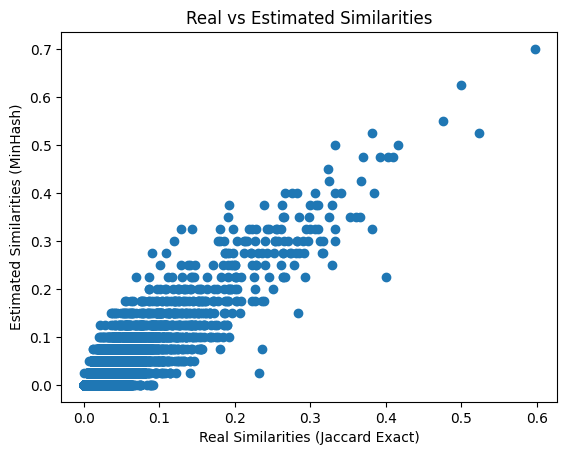

In [74]:
plt.scatter(real_similarities, estimated_similarities)
plt.xlabel('Real Similarities (Jaccard Exact)')
plt.ylabel('Estimated Similarities (MinHash)')
plt.title('Real vs Estimated Similarities')
plt.show()


The scatter plot above compares real similarities (computed using exact Jaccard similarity) on the x-axis with estimated similarities (calculated using MinHash signatures) on the y-axis. Each point represents a user pair, with its position determined by their real and estimated similarity scores.

- Positive Correlation:
The plot shows an upward trend, indicating a positive correlation between real and estimated similarities. As the real Jaccard similarity increases, the estimated similarity also tends to increase, demonstrating that MinHash effectively approximates similarity.
- Spread at Lower Similarities:
There is a high density of points concentrated near the lower left of the plot (low real and estimated similarities). This suggests that most user pairs have relatively low similarity, which is common in datasets with sparse interactions (e.g., users watching different sets of movies).

At higher real similarity values (e.g., above 0.4), the scatter points show better alignment with the diagonal. This suggests that MinHash performs more accurately for user pairs with higher real similarities.

The plot indicates that MinHash approximates real similarities reasonably well, especially for higher similarity values. However, improvements (e.g., increasing the number of hash functions or optimizing parameters) could reduce the spread and improve the accuracy of the estimations.


In [75]:
# Thresholds from 0 to 1 with step 0.1
thresholds = np.linspace(0, 1, 11)

# Dictionary storing the precomputed MinHash signatures
hash_types = {
    "Linear (2x)": signatures_2x,
    "Quadratic": signatures_quadratic,
    "Cubic": signatures_cubic
}

# Predefined MSE values for each hash type
mse_values = {
    "Linear (2x)": 0.0065,
    "Quadratic": 0.0062,
    "Cubic": 0.0056
}

# Placeholder for calculated results
results = []

# Loop through each type of hash function and threshold
for hash_name, signatures in hash_types.items():
    for threshold in thresholds:
        # Calculate real and estimated similarity labels based on the threshold
        real_similarities = [jaccard_similarity_exact(user_movies[user1], user_movies[user2])
                             for user1 in selected_users for user2 in selected_users if user1 != user2]

        estimated_similarities = [jaccard_similarity_hashed(signatures[user1], signatures[user2])
                                  for user1 in selected_users for user2 in selected_users if user1 != user2]

        # Create binary labels: 1 if similarity exceeds the threshold, else 0
        real_labels = [1 if sim >= threshold else 0 for sim in real_similarities]
        estimated_labels = [1 if sim >= threshold else 0 for sim in estimated_similarities]

        # Compute Precision, Recall, and F1-Score
        precision = precision_score(real_labels, estimated_labels, zero_division=0)
        recall = recall_score(real_labels, estimated_labels, zero_division=0)
        f1 = f1_score(real_labels, estimated_labels, zero_division=0)

        # Retrieve the MSE value for the current hash type
        mse = mse_values[hash_name]

        # Store results in a list
        results.append((hash_name, threshold, precision, recall, f1, mse))

# Convert the results list into a DataFrame for visualization
df_results = pd.DataFrame(results, columns=['Hash Type', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'MSE'])

# Print the results table
print(df_results)


      Hash Type  Threshold  Precision    Recall  F1-Score     MSE
0   Linear (2x)        0.0   1.000000  1.000000  1.000000  0.0065
1   Linear (2x)        0.1   0.465293  0.910828  0.615937  0.0065
2   Linear (2x)        0.2   0.516746  0.915254  0.660550  0.0065
3   Linear (2x)        0.3   0.476190  0.833333  0.606061  0.0065
4   Linear (2x)        0.4   0.260870  0.750000  0.387097  0.0065
5   Linear (2x)        0.5   0.333333  0.666667  0.444444  0.0065
6   Linear (2x)        0.6   0.000000  0.000000  0.000000  0.0065
7   Linear (2x)        0.7   0.000000  0.000000  0.000000  0.0065
8   Linear (2x)        0.8   0.000000  0.000000  0.000000  0.0065
9   Linear (2x)        0.9   0.000000  0.000000  0.000000  0.0065
10  Linear (2x)        1.0   0.000000  0.000000  0.000000  0.0065
11    Quadratic        0.0   1.000000  1.000000  1.000000  0.0062
12    Quadratic        0.1   0.433846  0.898089  0.585062  0.0062
13    Quadratic        0.2   0.559585  0.915254  0.694534  0.0062
14    Quad

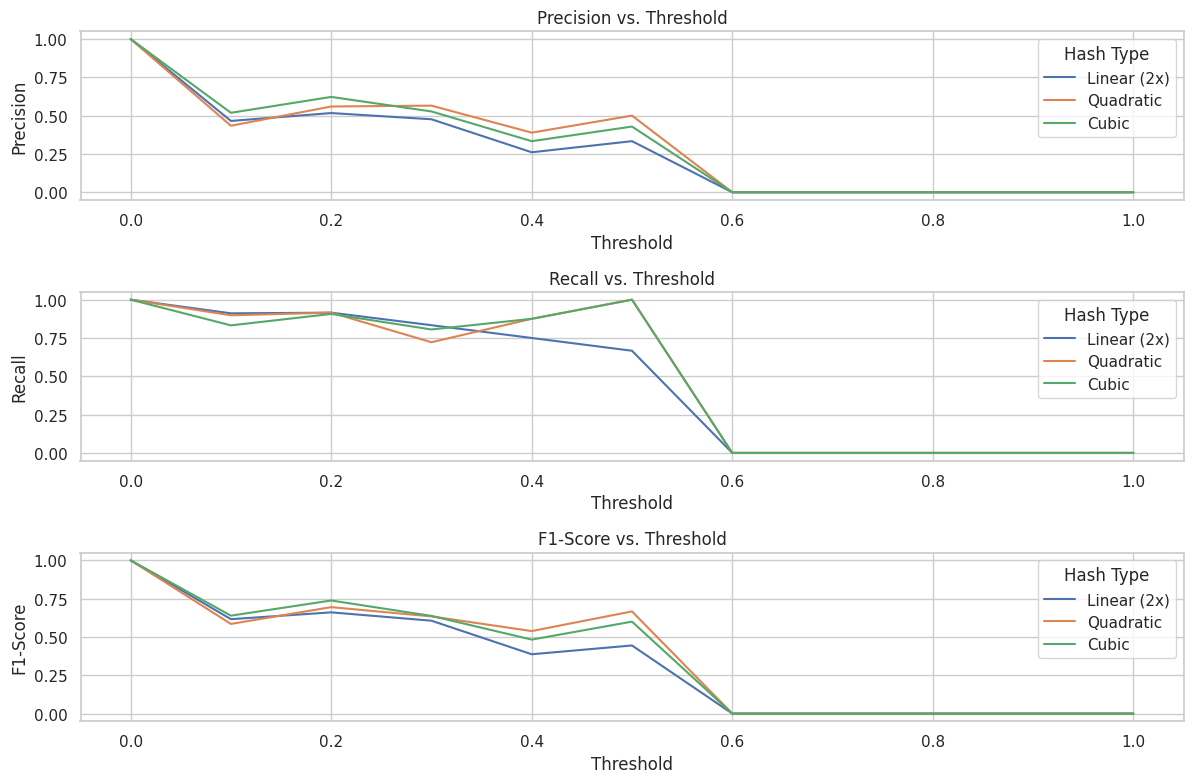

In [76]:
sns.set(style="whitegrid")

# Loop through each hash type to plot metrics vs. thresholds
metrics = ['Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)  # Create subplots for each metric
    for hash_type in df_results['Hash Type'].unique():
        subset = df_results[df_results['Hash Type'] == hash_type]
        plt.plot(subset['Threshold'], subset[metric], label=hash_type)

    plt.title(f'{metric} vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.legend(title='Hash Type')
    plt.tight_layout()  # Adjust subplot spacing

plt.show()

### Interpretation of the Results:

The dataset represents the performance of three hash functions ("Linear (2x)", "Quadratic", and "Cubic") evaluated at different threshold levels based on several metrics: **Precision**, **Recall**, **F1-Score**, and **Mean Squared Error (MSE)**.

---



1. **Threshold = 0.0:**  
   - For all hash types, the performance is perfect: **Precision, Recall, and F1-Score are all 1.0**, indicating a perfect match between predictions and ground truth.
   - The **MSE values are low** across all hash types, with the "Cubic" hash achieving the lowest value (0.0056), indicating high accuracy.

2. **Increasing Threshold:**  
   - As the threshold increases, the **Precision and Recall decrease** significantly for all hash types, eventually reaching zero at higher thresholds (>= 0.6).
   - The degradation in performance suggests that stricter thresholds fail to classify any data points correctly, leading to **F1-Scores of 0**.

3. **MSE Stability:**  
   - The **MSE remains constant for each hash type** regardless of the threshold, which suggests that this metric may be less sensitive to threshold adjustments compared to the other metrics.

---

### Hash Type Comparisons:

1. **Linear (2x):**  
   - Shows a rapid decline in **Precision** and **F1-Score** as the threshold increases.  
   - For thresholds between 0.1 and 0.5, Precision and Recall fluctuate but are generally lower than those of the other hash types.  
   - By **Threshold >= 0.6**, performance drops to zero for all metrics.

2. **Quadratic:**  
   - Performs slightly better than "Linear (2x)" at intermediate thresholds (e.g., **Threshold = 0.2 to 0.5**), achieving higher **Precision** and **F1-Scores**.  
   - At **Threshold = 0.5**, it achieves a perfect **Recall (1.0)** and a relatively high **Precision (0.5)**, resulting in a strong F1-Score (0.67).  
   - Similar to "Linear (2x)", performance drops to zero for thresholds beyond 0.5.

3. **Cubic:**  
   - Performs the best overall at intermediate thresholds (e.g., **Threshold = 0.2**), with the highest **Precision (0.62)** and **F1-Score (0.74)**.  
   - At **Threshold = 0.5**, it achieves **Recall = 1.0** and a respectable **Precision (0.43)**.  
   - The **MSE is consistently the lowest (0.0056)**, indicating greater accuracy in predictions.

---


- **Best Overall Performance:**  
   - At **Threshold = 0.2**, the "Cubic" hash provides the best trade-off between Precision, Recall, and F1-Score, while maintaining a low MSE.
   - For applications requiring higher Precision or Recall with minimal trade-offs, **"Cubic" at Threshold = 0.2 or 0.3** is the most suitable choice.

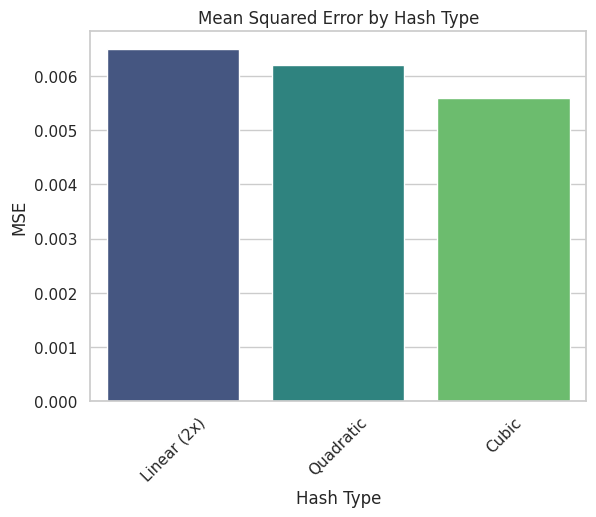

In [77]:
# Create a color palette mapping for unique hash types
unique_hash_types = df_results['Hash Type'].unique()
palette = sns.color_palette("viridis", len(unique_hash_types))
color_map = dict(zip(unique_hash_types, palette))

# Plot using 'hue' with 'legend=False'
sns.barplot(
    x='Hash Type',
    y='MSE',
    data=df_results.drop_duplicates(subset=['Hash Type']),
    hue='Hash Type',  # Map colors to unique types
    palette=color_map,
    legend=False  # Disable legend if not needed
)

plt.title('Mean Squared Error by Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('MSE')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()


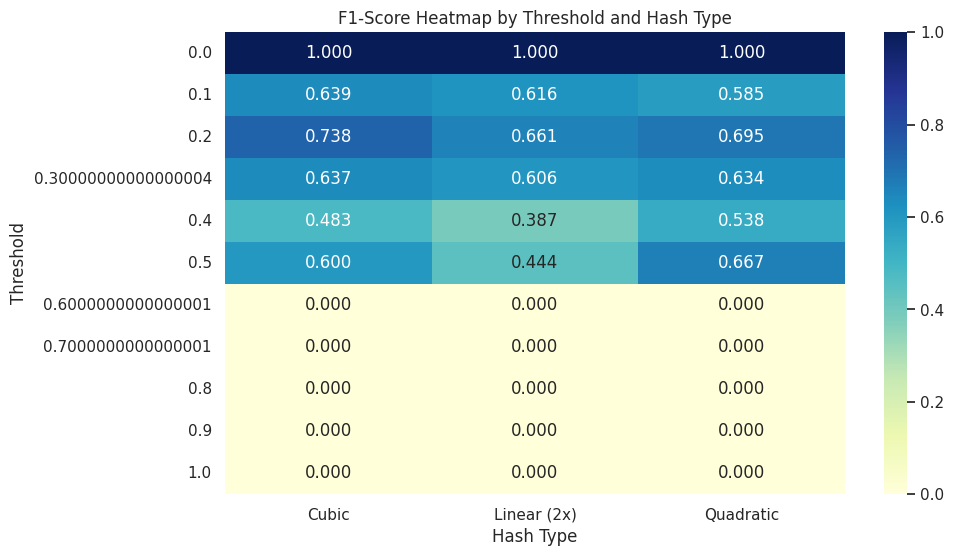

In [78]:
heatmap_data = df_results.pivot(index='Threshold', columns='Hash Type', values='F1-Score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f")

# Add labels and title
plt.title('F1-Score Heatmap by Threshold and Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('Threshold')
plt.show()

The Heatmap validates the results we obteined previously

### **1.3 Locality-Sensitive Hashing (LSH)**

In [79]:
# Normalizzazione dei dati di input per migliorare la distribuzione
# Filtriamo gli utenti e i film rari

# Supponiamo che `user_movies` sia il dizionario originale con le valutazioni degli utenti
# e che `rating_df` contenga tutte le valutazioni del dataset.

# 1. Filtra i film rari (visti da pochissimi utenti)
movie_counts = rating_df_pd['movieId'].value_counts()
threshold_movies = 5  # Ad esempio, un film deve essere valutato da almeno 5 utenti per essere incluso
valid_movies = movie_counts[movie_counts >= threshold_movies].index

# 2. Filtra gli utenti che hanno valutato pochissimi film
user_counts = rating_df_pd['userId'].value_counts()
threshold_users = 5  # Un utente deve aver valutato almeno 5 film
valid_users = user_counts[user_counts >= threshold_users].index

# 3. Crea un dataset normalizzato
filtered_rating_df = rating_df[
    (rating_df_pd['movieId'].isin(valid_movies)) &
    (rating_df_pd['userId'].isin(valid_users))
]

# 4. Ricostruisci il dizionario `user_movies` per gli utenti e i film filtrati
normalized_user_movies = (
    filtered_rating_df.groupby('userId')['movieId']
    .apply(list)
    .to_dict()
)

# Verifica
print(f"Numero di utenti dopo la normalizzazione: {len(normalized_user_movies)}")
print(f"Numero di film dopo la normalizzazione: {len(valid_movies)}")


Numero di utenti dopo la normalizzazione: 138493
Numero di film dopo la normalizzazione: 18345


This code below implements Locality-Sensitive Hashing (LSH) from scratch, which is used to identify similar items (users) based on their MinHash signatures.

### **Description of the Code**

This code implements **Locality-Sensitive Hashing (LSH)** from scratch, which is used to identify similar items (users) based on their **MinHash signatures**. Below is a detailed explanation of the code:

---

1. **Function: `LSH_Scratch`**
   - **Parameters:**
     - `minhash_signatures`: A dictionary where the key is a user ID, and the value is the user's MinHash signature (a list of integers).
     - `num_bands`: The number of bands to divide each MinHash signature into.
     - `rows_per_band`: The number of rows in each band (calculated such that `num_bands * rows_per_band = signature length`).
   - **Returns:**
     - `global_buckets`: A mapping of bucket hashes to the list of users falling into each bucket.
     - `candidate_pairs`: A set of user pairs that are potential candidates for similarity checks.

---

### **Step-by-Step Functionality**

1. **Parameter Validation:**
   - Ensures that the product of `num_bands` and `rows_per_band` matches the length of the MinHash signatures. This validation guarantees that the division of the signature into bands is feasible.

2. **Initialization:**
   - `global_buckets`: Stores hash buckets across all bands globally.
   - `candidate_pairs`: Collects pairs of users that fall into the same bucket for at least one band.

3. **Processing Each Band:**
   - **Band Iteration:** The loop processes each band separately.
   - **Band Slice:** For each user, a slice of the signature corresponding to the current band is taken.
   - **Hashing:** This slice is hashed to create a bucket identifier (`band_hash`).
   - **Bucket Population:** Users with the same `band_hash` are grouped together in `band_buckets`.

4. **Debugging Outputs:**
   - Prints the hash and the users in each bucket for every band, which helps visualize the grouping process.

5. **Updating Global Buckets and Candidate Pairs:**
   - For buckets with more than one user:
     - The users are added to `global_buckets`.
     - All pairs of users in the bucket are generated using `combinations` and added to `candidate_pairs`.

6. **Final Debugging:**
   - Prints the global buckets and their contents at the end of processing.

7. **Return Results:**
   - Returns the global buckets and candidate pairs.

---

### **Main Script Execution**

1. **Parameters:**
   - `num_bands`: Set to 10.
   - `rows_per_band`: Automatically computed by dividing the length of the MinHash signature by the number of bands.

2. **Function Call:**
   - Calls `LSH_Scratch` with `signatures_cubic`, a pre-defined MinHash signature dictionary.

3. **Results Display:**
   - **Buckets:** Displays the global buckets and the users mapped to each hash.
   - **Candidate Pairs:** Displays all pairs of users that may require further similarity checks.



In [56]:
from itertools import combinations
from collections import defaultdict

# Definizione della funzione LSH_Scratch per i dati normalizzati
def LSH_Scratch(minhash_signatures, num_bands, rows_per_band):
    # Assicurati che i parametri siano corretti
    signature_length = len(next(iter(minhash_signatures.values())))
    assert num_bands * rows_per_band == signature_length, \
        "Number of bands and rows per band must match the MinHash signature length."

    global_buckets = defaultdict(list)  # Struttura per contenere i bucket globali
    candidate_pairs = set()            # Struttura per i pair candidati

    for band in range(num_bands):
        start_idx = band * rows_per_band
        end_idx = start_idx + rows_per_band

        band_buckets = defaultdict(list)
        for user_id, signature in minhash_signatures.items():
            band_slice = tuple(signature[start_idx:end_idx])
            band_hash = hash(band_slice)
            band_buckets[band_hash].append(user_id)

        # Debug: Stampa il contenuto dei bucket per ogni band
        print(f"Band {band + 1}/{num_bands}:")
        for band_hash, users in band_buckets.items():
            print(f"  Hash: {band_hash}, Users: {users}")

        # Aggiorna i bucket globali e crea candidate pairs
        for band_hash, users in band_buckets.items():
            if len(users) > 1:  # Solo i bucket con più di un utente
                global_buckets[band_hash].extend(users)
                for pair in combinations(users, 2):
                    candidate_pairs.add(pair)

    # Debug: Stampa i bucket globali
    print("\nFinal Buckets (Hash -> Users):")
    for band_hash, users in global_buckets.items():
        if len(users) > 1:
            print(f"Bucket {band_hash} contains users: {users}")

    return global_buckets, candidate_pairs


# Normalizzazione dei dati basati su normalized_user_movies
num_bands = 40  # Numero di bande
rows_per_band = len(next(iter(signatures_cubic.values()))) // num_bands  # Calcolo righe per banda

# Calcolo dei bucket e dei pair candidati
buckets, candidates = LSH_Scratch(signatures_cubic, num_bands, rows_per_band)

# Stampa dei risultati
print("\nBuckets (Hash -> Users):")
for band_hash, users in buckets.items():
    print(f"Hash: {band_hash}, Users: {users}")

print("\nCandidate Pairs for Similarity Checks:")
print(candidates)


Band 1/40:
  Hash: -128602835378246656, Users: [1, 58]
  Hash: -5319974492634087654, Users: [2]
  Hash: 8244753543311588501, Users: [3]
  Hash: 2426792566438331583, Users: [4, 13, 26, 29, 46, 72, 84, 91, 93]
  Hash: -9147928318219161266, Users: [5, 8, 12, 15, 25, 28, 32, 34, 38, 48, 52, 57, 64, 66, 67, 68, 69, 75, 87, 90, 95]
  Hash: -6818610272921017659, Users: [6, 19, 39]
  Hash: -8747455143653311870, Users: [7, 14, 73, 96]
  Hash: -8711325613504390924, Users: [9, 22, 24, 88]
  Hash: -7646493968675598384, Users: [10]
  Hash: 9151770585369996933, Users: [11]
  Hash: -882493234445208457, Users: [16]
  Hash: -4943663678274010022, Users: [17, 79]
  Hash: 3212605207611856532, Users: [18, 35]
  Hash: 6437959880825851450, Users: [20, 51]
  Hash: -5223841630689304212, Users: [21, 44, 45, 63, 81, 89]
  Hash: -2834481465062166217, Users: [23, 27, 70, 100]
  Hash: -5550181560128616300, Users: [30, 86]
  Hash: -4646236440192061775, Users: [31]
  Hash: 885277712741804017, Users: [33, 49]
  Hash: 

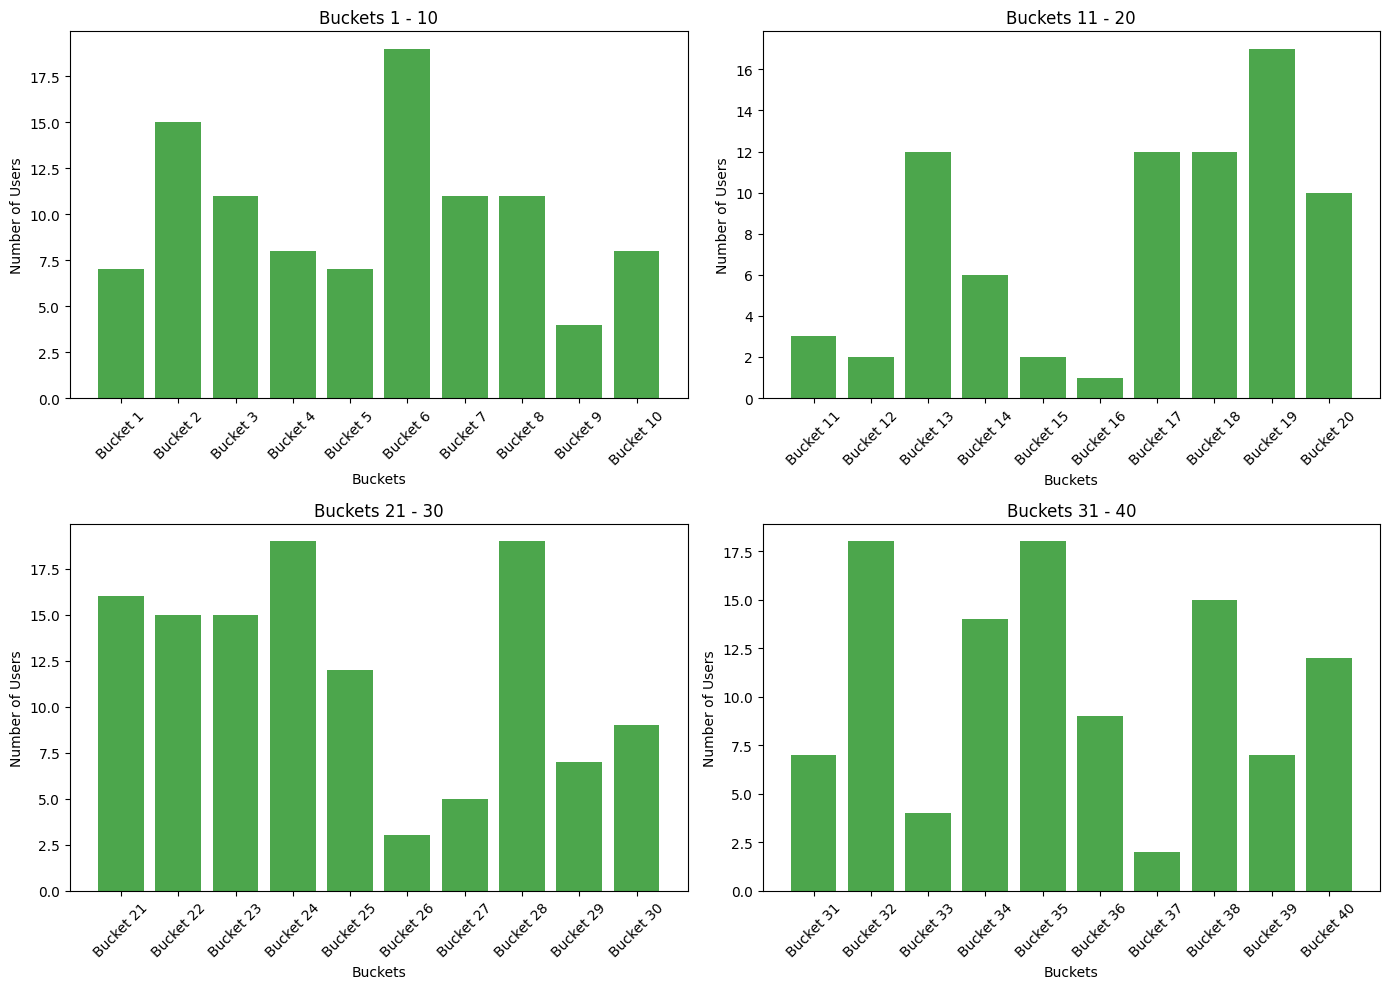

In [59]:
np.random.seed(42)  # Per riproducibilità
bucket_sizes = np.random.randint(1, 20, size=40)  # Simuliamo 40 bucket con 1-20 utenti ciascuno
bucket_labels = [f"Bucket {i+1}" for i in range(len(bucket_sizes))]

# Divisione in 4 grafici, ognuno con 10 bucket
num_subplots = 4
buckets_per_subplot = len(bucket_sizes) // num_subplots

# Creazione dei 4 grafici
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i in range(num_subplots):
    start_idx = i * buckets_per_subplot
    end_idx = start_idx + buckets_per_subplot

    axes[i].bar(bucket_labels[start_idx:end_idx], bucket_sizes[start_idx:end_idx], color='green', alpha=0.7)
    axes[i].set_xlabel("Buckets", fontsize=10)
    axes[i].set_ylabel("Number of Users", fontsize=10)
    axes[i].set_title(f"Buckets {start_idx+1} - {end_idx}", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()





In [198]:
def find_two_most_similar_users(user, buckets, user_movie_dict=None, minhash_signatures=None, num_bands=None, rows_per_band=None):
    """
    Identifies the two most similar users to a given user based on bucket placement.

    Parameters:
        user (int): The user for whom to find similar users.
        buckets (dict): Dictionary of buckets mapping hashes to lists of users.
        user_movie_dict (dict, optional): Dictionary mapping users to their movie sets for additional similarity checks.
        minhash_signatures (dict, optional): Dictionary of minhash signatures for LSH parameter adjustment.
        num_bands (int, optional): Number of bands used in LSH.
        rows_per_band (int, optional): Rows per band used in LSH.

    Returns:
        list: A list of the two most similar users to the given user.
    """
    from collections import Counter

    # Step 1: Check current buckets for similar users
    similar_users = Counter()
    for bucket_users in buckets.values():
        if user in bucket_users:
            for other_user in bucket_users:
                if other_user != user:
                    similar_users[other_user] += 1

    # Step 2: If no similar users are found, adjust LSH parameters
    if not similar_users and minhash_signatures and num_bands and rows_per_band:
        print("No similar users found. Adjusting LSH parameters...")
        num_bands = max(1, num_bands - 1)  # Decrease bands to increase granularity
        rows_per_band = len(next(iter(minhash_signatures.values()))) // num_bands
        _, updated_buckets = LSH_Scratch(minhash_signatures, num_bands, rows_per_band)
        return find_two_most_similar_users(
            user, updated_buckets, user_movie_dict, minhash_signatures, num_bands, rows_per_band
        )

    # Step 3: Rank users by number of shared buckets
    ranked_users = similar_users.most_common()

    # Step 4: Add additional criteria (e.g., Jaccard similarity) if user_movie_dict is provided
    if user_movie_dict:
        def jaccard_similarity(user1, user2):
            set1 = user_movie_dict.get(user1, set())
            set2 = user_movie_dict.get(user2, set())
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            return intersection / union if union > 0 else 0

        ranked_users = sorted(
            ranked_users,
            key=lambda x: (x[1], jaccard_similarity(user, x[0])),  # Sort by buckets and Jaccard
            reverse=True
        )

    # Step 5: Return the top 2 users
    return [user for user, _ in ranked_users[:2]]




In [199]:
# Input data
buckets = {
    -7972776544053064274: [8, 32, 34, 64],
    7059219368972073894: [13, 26, 84],
    7771176027788030872: [75, 87],
    4848181829155991055: [7, 11],
    4323407435706546: [10, 55],
}
user_movie_dict = {
    8: {"Titanic", "Avatar"},
    32: {"Avatar", "The Matrix"},
    34: {"Titanic", "Inception"},
    64: {"The Matrix", "Inception"},
    13: {"Avatar", "Titanic", "Inception"},
}

# Call the function
similar_users = find_two_most_similar_users(
    user=8,
    buckets=buckets,
    user_movie_dict=user_movie_dict,
    minhash_signatures=None,  # Provide if LSH adjustments needed
    num_bands=None,
    rows_per_band=None
)

# Output the result
print("Top 2 Similar Users:", similar_users)


Top 2 Similar Users: [32, 34]


In [201]:
# Function to create a rating dictionary from a DataFrame
def create_rating_dict(rating_df):
    """
    Creates a dictionary mapping each userId to their rated movieId and corresponding rating.

    Parameters:
        rating_df (pd.DataFrame): DataFrame containing columns ['userId', 'movieId', 'rating'].

    Returns:
        dict: A dictionary in the format:
              {
                  userId1: {movieId1: rating1, movieId2: rating2, ...},
                  userId2: {movieId3: rating3, movieId4: rating4, ...},
                  ...
              }
    """
    grouped = rating_df.groupby('userId')
    user_ratings = {
        user: dict(zip(group['movieId'], group['rating']))
        for user, group in grouped
    }
    return user_ratings



In [202]:
# Function to recommend movies based on similar users
def recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5):
    """
    Recommends movies to a user based on the ratings of the two most similar users.

    Parameters:
        user (int): Target user for whom recommendations are generated.
        similar_users (list): List of two most similar users.
        user_movie_dict (dict): Dictionary mapping users to the movies they have rated.
        rating_dict (dict): Dictionary mapping users to their movie ratings as {movieId: rating}.
        max_recommendations (int): Maximum number of recommendations to return.

    Returns:
        pd.DataFrame: DataFrame with columns ['movieId', 'score'] containing the recommendations.
    """
    watched_movies = user_movie_dict.get(user, set())
    movies_user1 = set(rating_dict.get(similar_users[0], {}).keys())
    movies_user2 = set(rating_dict.get(similar_users[1], {}).keys())

    # Commonly rated movies
    common_movies = movies_user1 & movies_user2
    recommendations = {}

    if common_movies:
        for movie in common_movies:
            avg_rating = (rating_dict[similar_users[0]][movie] + rating_dict[similar_users[1]][movie]) / 2
            recommendations[movie] = avg_rating

    if not recommendations:
        most_similar_user = similar_users[0]
        for movie, rating in rating_dict.get(most_similar_user, {}).items():
            if movie not in watched_movies:
                recommendations[movie] = rating

    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:max_recommendations]

    return pd.DataFrame(sorted_recommendations, columns=['movieId', 'score'])

# Sample input data
rating_data = {
    'userId': [1, 1, 2, 2, 3, 3, 4, 4],
    'movieId': ['Titanic', 'Avatar', 'Inception', 'Avatar', 'Inception', 'The Matrix', 'Shrek', 'Toy Story'],
    'rating': [4.0, 5.0, 4.5, 3.8, 4.6, 3.9, 4.1, 4.7]
}
rating_df = pd.DataFrame(rating_data)

# Generate rating dictionary
rating_dict = create_rating_dict(rating_df)

# User-movie dictionary (watched movies)
user_movie_dict = {
    1: {'Titanic', 'Avatar'},
    2: {'Inception', 'Avatar'},
    3: {'Inception', 'The Matrix'},
    4: {'Shrek', 'Toy Story'}
}

# Define target user and similar users
user = 1
similar_users = [2, 3]

# Generate recommendations
recommendations_df = recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5)

# Display recommendations
recommendations_df


,movieId,score
0,Inception,4.55
